# PHASE 3 PROJECT

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import plot_confusion_matrix, recall_score, accuracy_score, precision_score, f1_score, confusion_matrix

%matplotlib inline

### Data Cleaning

In [2]:
# Upload the data
data = pd.read_csv('data/data.csv')

In [3]:
# Dropping columns we are not going to use

df = data.drop(['phone number', 'total intl calls', 'total intl charge', 'total intl minutes'], axis=1)

In [4]:
# Making Yes and No into 0 and 1

df['international plan'] = df['international plan'].map(dict(yes=1, no=0))
df['voice mail plan'] = df['voice mail plan'].map(dict(yes=1, no=0))

In [5]:
# Making sure each columns is the data type it is supposed to be

df['area code'] = df['area code'].astype(object)

In [6]:
# Making 3 different data sets to isolate minutes called, number of calls, total charge

# df_minutes = df.drop(['total day calls', 'total day charge', 'total eve calls', 'total eve charge', 'total night calls',
#                       'total night charge', 'total intl calls', 'total intl charge'], axis=1)
# df_calls = df.drop(['total day minutes', 'total day charge', 'total eve minutes', 'total eve charge',
#                    'total night minutes', 'total night charge','total intl minutes', 'total intl charge'], axis=1)
# df_charge = df.drop(['total day calls', 'total day minutes', 'total eve calls', 'total eve minutes',
#                     'total night calls', 'total night minutes', 'total intl calls', 'total intl minutes'], axis=1)

### Data Visualization

<AxesSubplot:>

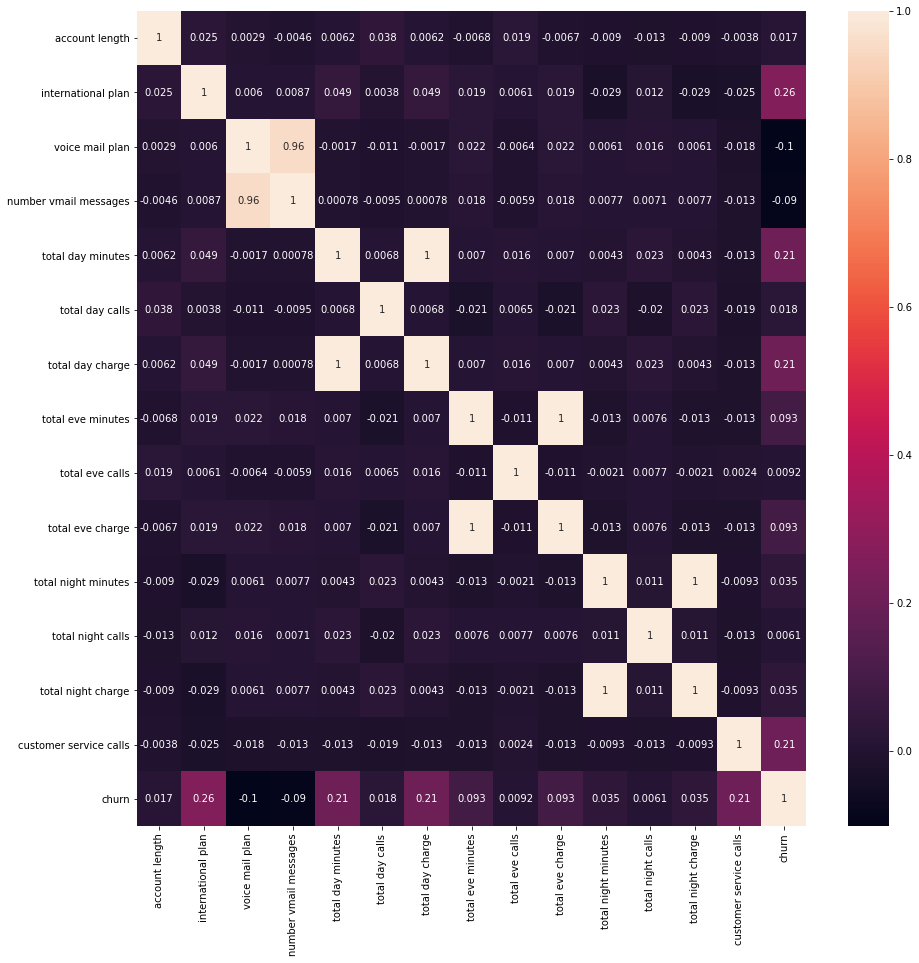

In [7]:
# Our target is churn rate, there is no strong correlation with any other variable, this is good news for any linear regression
# we plan on testing

plt.figure(figsize=(15,15))
sns.heatmap(df.corr(), annot = True)

### Dummy Model

In [8]:
# We see that we have a 85.5% success rate if we predict false all the time

df['churn'].value_counts(normalize=True)

False    0.855086
True     0.144914
Name: churn, dtype: float64

### Pipeline

In [9]:
# Get list of numerical and object columns

num_cols = df.select_dtypes(include=['float', 'int']).columns.tolist()
obj_cols = df.select_dtypes(include=['object']).columns.tolist()

In [10]:
# Create a ColumnTransformer to handle numerical and object columns separately

preprocessor = ColumnTransformer(
    transformers=[
        ('ss', StandardScaler(), num_cols),
        ('ohe', OneHotEncoder(), obj_cols)
    ]
)

### Train / Test data

In [11]:
# Split the data into features and labels

X = df.drop('churn', axis=1)
y = df['churn']

In [12]:
# Split the data into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# Transform the train and test data

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

### Create ML Models

In [14]:
# Initialize the models

log_reg = LogisticRegression()
random_forest = RandomForestClassifier()
decision_tree = DecisionTreeClassifier()
knn = KNeighborsClassifier()

In [15]:
log_reg.fit(X_train_transformed, y_train)

LogisticRegression()

In [16]:
random_forest.fit(X_train_transformed, y_train)

RandomForestClassifier()

In [17]:
decision_tree.fit(X_train_transformed, y_train)

DecisionTreeClassifier()

In [18]:
knn.fit(X_train_transformed, y_train)

KNeighborsClassifier()

In [19]:
# Evaluate the models on the test data
print('Logistic Regression: ', log_reg.score(X_test_transformed, y_test))
print('Random Forest: ', random_forest.score(X_test_transformed, y_test))
print('Decision Tree: ', decision_tree.score(X_test_transformed, y_test))
print('K-Nearest Neighbors: ', knn.score(X_test_transformed, y_test))

Logistic Regression:  0.8545727136431784
Random Forest:  0.8845577211394303
Decision Tree:  0.8185907046476761
K-Nearest Neighbors:  0.8650674662668666


### Confusion Matrix

Looking at the true positives and true negatives

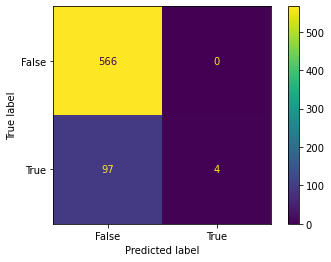

In [20]:
plot_confusion_matrix(log_reg, X_test_transformed, y_test)

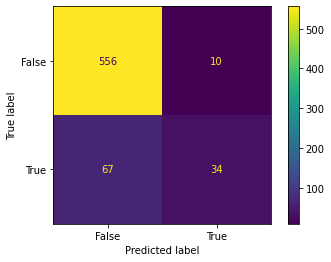

In [21]:
plot_confusion_matrix(random_forest, X_test_transformed, y_test)

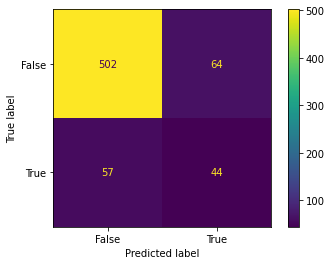

In [22]:
plot_confusion_matrix(decision_tree, X_test_transformed, y_test)

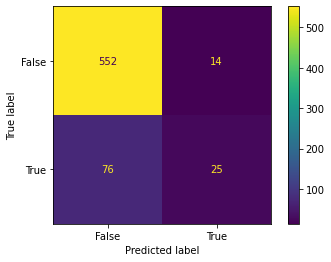

In [23]:
plot_confusion_matrix(knn, X_test_transformed, y_test)

### Random Forest Tuned
I am going to use "Random Forest" since it was the better performing model out of the 4.

In [24]:
# Specify the hyperparameters to tune

parameters = {'n_estimators': [10, 50, 100, 200],
              'criterion': ['gini', 'entropy'],
              'max_depth': [None, 5, 10], 
              'max_features': ['auto', 'sqrt']}

In [25]:
grid_search = GridSearchCV(random_forest, parameters, cv=5)
grid_search.fit(X=X_train_transformed, y=y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 10],
                         'max_features': ['auto', 'sqrt'],
                         'n_estimators': [10, 50, 100, 200]})

In [26]:
print("Best hyperparameters:", grid_search.best_params_)

Best hyperparameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 100}


In [27]:
print("Best score for tuned hyperparameters: ", grid_search.best_score_)

Best score for tuned hyperparameters:  0.8837180541209044


In [28]:
tuned_random_forest = RandomForestClassifier(criterion='entropy', max_features= 'auto', n_estimators=50)

In [29]:
tuned_random_forest.fit(X_train_transformed, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=50)

In [30]:
tuned_random_forest.score(X_test_transformed, y_test)

0.8845577211394303

In [31]:
prediction = tuned_random_forest.predict(X_test_transformed)

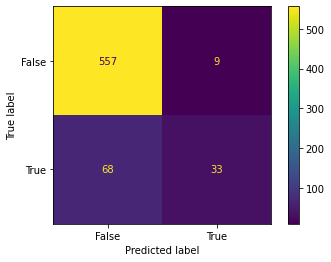

In [32]:
plot_confusion_matrix(tuned_random_forest, X_test_transformed, y_test)

### Decission Tree Tuned -

In [33]:
dt_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6]
}

In [34]:
grid_search2 = GridSearchCV(decision_tree, dt_params, cv=5)
grid_search2.fit(X=X_train_transformed, y=y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 3, 4, 5, 6],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6],
                         'min_samples_split': [2, 5, 10]})

In [35]:
print("Best hyperparameters:", grid_search2.best_params_)

Best hyperparameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 5}


In [36]:
print("Best score for tuned hyperparameters: ", grid_search.best_score_)

Best score for tuned hyperparameters:  0.8837180541209044


In [37]:
tuned_decision_tree = DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_leaf=5, min_samples_split=2)

In [38]:
tuned_decision_tree.fit(X_train_transformed, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=5)

In [39]:
tuned_decision_tree.score(X_test_transformed, y_test)

0.8800599700149925

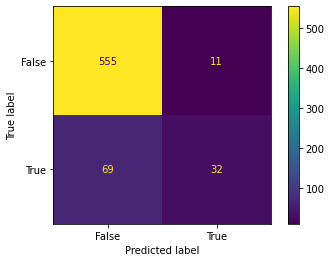

In [40]:
plot_confusion_matrix(tuned_decision_tree, X_test_transformed, y_test)

### --- Difference between churn or no churn ---

Make 2 different data sets to work with

In [41]:
f_df = df[df['churn'] == False]

In [42]:
t_df = df[df['churn'] == True]

Here is a list worth taking a look at since there is a noticeable between positive churn and negative churn 
- International Plan
- Voice Plan
- Customer Service Calls

In [43]:
columns_to_show = ['total day minutes', 'total eve minutes', 'total night minutes']
df.groupby(['churn'])[columns_to_show].agg([np.mean, np.median, np.std, np.min, np.max])

total day minutes                               total eve minutes  \
                   mean median        std amin   amax              mean   
churn                                                                     
False        175.175754  177.2  50.181655  0.0  315.6        199.043298   
True         206.914079  217.6  68.997792  0.0  350.8        212.410145   

                                     total night minutes                     \
      median        std  amin   amax                mean  median        std   
churn                                                                         
False  199.6  50.292175   0.0  361.8          200.133193  200.25  51.105032   
True   211.3  51.728910  70.9  363.7          205.231677  204.80  47.132825   

                    
       amin   amax  
churn               
False  23.2  395.0  
True   47.4  354.9

In [44]:
pd.crosstab(df['churn'], df['international plan'])

international plan,0,1
churn,,
False,2664,186
True,346,137


In [45]:
pd.crosstab(df['churn'], df['voice mail plan'])

voice mail plan,0,1
churn,,
False,2008,842
True,403,80


In [46]:
pd.crosstab(df['churn'], df['customer service calls'])

customer service calls,0,1,2,3,4,5,6,7,8,9
churn,,,,,,,,,,
False,605,1059,672,385,90,26,8,4,1,0
True,92,122,87,44,76,40,14,5,1,2


# --- Visualization ---

In [47]:
# Splitting the data for ease of use
f_df = df[df['churn'] == False]
t_df = df[df['churn'] == True]

In [48]:
lul = f_df['international plan'].value_counts(normalize=True)

In [49]:
lol = t_df['international plan'].value_counts(normalize=True)

In [50]:
#sns.set(rc={"figure.dpi":100, 'savefig.dpi':200})
plt.style.use('ggplot')

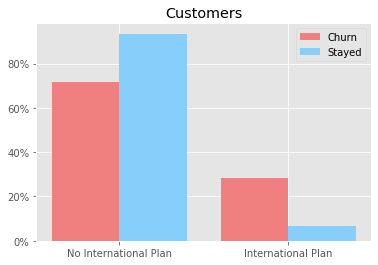

In [51]:
fig, ax = plt.subplots()

ax.bar(lol.index - 0.2, lol.values, width=0.4, color='lightcoral')

ax.bar(lol.index + 0.2, lul.values, width=0.4, color='lightskyblue')

ax.set_xticks(lol.index)
ax.set_xticklabels(['No International Plan', 'International Plan'])
ax.set_title('Customers')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.legend(['Churn', 'Stayed'])

plt.show()

### ---

In [52]:
lal = f_df['voice mail plan'].value_counts(normalize=True)
lel = t_df['voice mail plan'].value_counts(normalize=True)

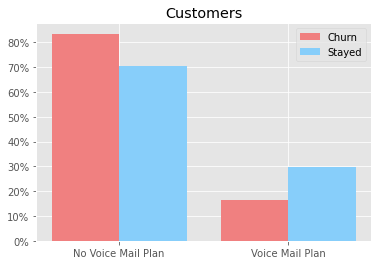

In [53]:
fig, ax = plt.subplots()

ax.bar(lel.index - 0.2, lel.values, width=0.4, color='lightcoral')

ax.bar(lel.index + 0.2, lal.values, width=0.4, color='lightskyblue')

ax.set_xticks(lol.index)
ax.set_xticklabels(['No Voice Mail Plan', 'Voice Mail Plan'])
ax.set_title('Customers')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.legend(['Churn', 'Stayed'])

plt.show()

In [54]:
WW = t_df['customer service calls'].mean()

In [55]:
XX = f_df['customer service calls'].mean()

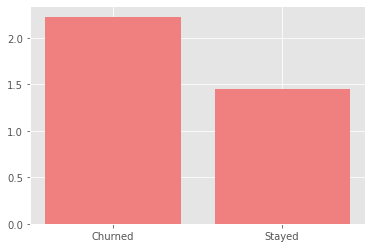

In [56]:
fig, ax = plt.subplots()

ax.bar(['Churned', 'Stayed'], [WW, XX], color='lightcoral')


plt.show()